In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [0]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

sample_data = next(iter(train_loader))

In [0]:
sample_data = next(iter(train_loader))

In [0]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image,cmap='inferno')


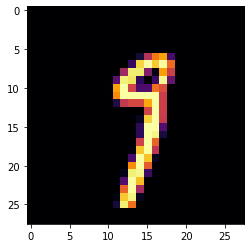

In [0]:
plot_img(sample_data[0][2])

In [0]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [0]:
model = Net()
if is_cuda:
    model.cuda()

In [0]:
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [0]:
data , target = next(iter(train_loader))
output = model(data.cuda().clone().detach())

In [0]:
output.size()
target.size()

torch.Size([32])

In [0]:
def fit(epoch,model,data_loader,phase='training'):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = torch.tensor(data, requires_grad=True),torch.tensor(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [0]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.59 and training accuracy is 48843/60000      81.4
validation loss is  0.14 and validation accuracy is 9570/10000      95.7
training loss is  0.18 and training accuracy is 56840/60000     94.73
validation loss is 0.079 and validation accuracy is 9753/10000     97.53
training loss is  0.14 and training accuracy is 57427/60000     95.71
validation loss is 0.067 and validation accuracy is 9771/10000     97.71
training loss is  0.13 and training accuracy is 57803/60000     96.34
validation loss is 0.058 and validation accuracy is 9811/10000     98.11
training loss is  0.11 and training accuracy is 58074/60000     96.79
validation loss is 0.053 and validation accuracy is 9817/10000     98.17
training loss is   0.1 and training accuracy is 58178/60000     96.96
validation loss is 0.051 and validation accuracy is 9827/10000     98.27
training loss is 0.096 and training accuracy is 58335/60000     97.22
validation loss is 0.041 and validation accuracy is 9868/10000     98.68

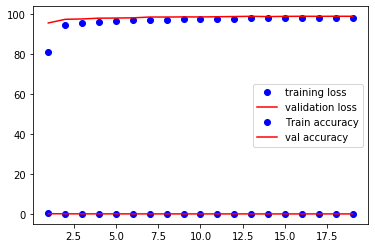

In [0]:
# plot results
plt.plot(range(1, len(train_losses) + 1), train_losses, 'bo', label = 'training loss')
plt.plot(range(1, len(val_losses)+1), val_losses,'r',label = 'validation loss')
plt.legend()

plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'bo', label = 'Train accuracy')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, 'r', label = 'val accuracy')
plt.legend() 
